# GBAT trans-eQTL

In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))

In [2]:
setwd("~/project-gandalm/isoform_twas/gbat/")

### h2g

In [69]:
h2g <- fread("out/chrALL_perm_h2g.txt", data.table = F, fill = TRUE)
h2g <- h2g %>% filter(!gene == "gene")
h2g$h2g <- as.numeric(h2g$h2g)
h2g <- h2g[complete.cases(h2g),]
dim(h2g)
length(unique(h2g$gene))
head(h2g)

[1] 17642     2

[1] 17642

,gene,h2g
,<chr>,<dbl>
1,ENSG00000226864.2_5,0.30585313
2,ENSG00000107672.15_4,0.15019899
3,ENSG00000273891.1_7,0.17478500
4,ENSG00000138162.19_5,0.12380934
5,ENSG00000107679.14_3,0.06980185
6,ENSG00000166033.13_4,0.07393242


In [70]:
mean(h2g$h2g)

[1] 0.2435643

In [72]:
range(h2g$h2g)

[1] -0.4805677  3.8109975

In [73]:
h2g_sub <- h2g %>% filter(h2g > 0 & h2g < 1)

In [74]:
dim(h2g_sub)

[1] 16911     2

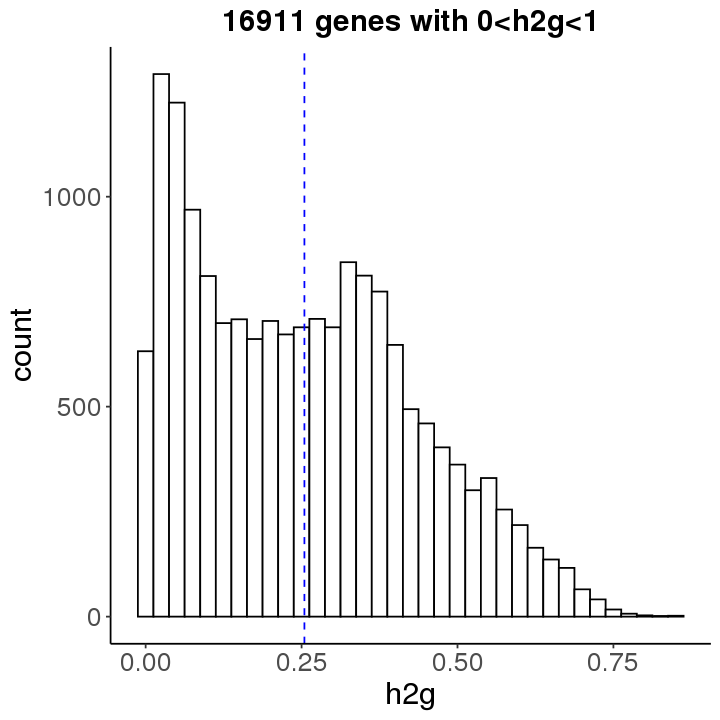

In [92]:
options(repr.plot.width = 6, repr.plot.height = 6)
p <- ggplot(h2g_sub, aes(x = h2g)) +
    geom_histogram(binwidth = 0.025, color = "black", fill = "white") +
    theme_classic() +
    geom_vline(xintercept = mean(h2g_sub$h2g), linetype = "dashed", color = "blue") +
    labs(title = "16911 genes with 0<h2g<1") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, face = "bold", hjust = 0.5)) 
    
p

In [93]:
ggsave("figures/h2g.png", p, height = 6, width = 6)

### pearson R2

In [84]:
r2 <- fread("out/pearsonR_chrALL.txt", data.table = F, fill = TRUE)
r2 <- r2 %>% filter(!genes == "genes")
r2$rsquared_goos_sva <- as.numeric(r2$rsquared_goos_sva)
r2 <- r2[complete.cases(r2),]
dim(r2)
head(r2)

[1] 17642     2

,genes,rsquared_goos_sva
,<chr>,<dbl>
1,ENSG00000226864.2_5,0.43067437
2,ENSG00000107672.15_4,0.05145882
3,ENSG00000273891.1_7,0.15226333
4,ENSG00000138162.19_5,-0.09209346
5,ENSG00000107679.14_3,0.12708331
6,ENSG00000166033.13_4,0.04679261


In [85]:
range(r2$rsquared_goos_sva)

[1] -0.3794944  0.6755979

In [90]:
mean(r2$rsquared_goos_sva)

[1] 0.03783285

In [96]:
sum(r2$rsquared_goos_sva > 0.1)
sum(r2$rsquared_goos_sva > 0.05)
sum(r2$rsquared_goos_sva > 0.01)

[1] 3072

[1] 6670

[1] 10721

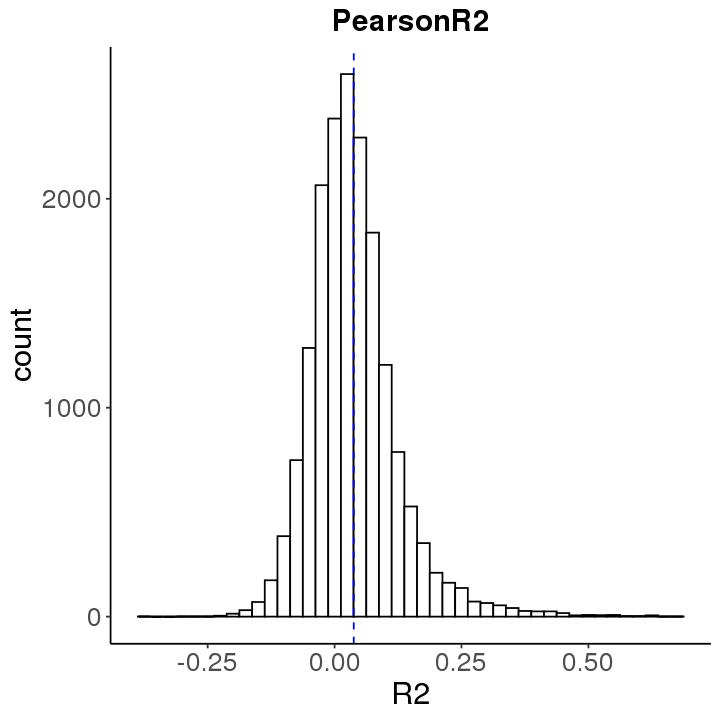

In [94]:
p <- ggplot(r2, aes(x = rsquared_goos_sva)) +
    geom_histogram(binwidth = 0.025, color = "black", fill = "white") +
    theme_classic() +
    geom_vline(xintercept = mean(r2$rsquared_goos_sva), linetype = "dashed", color = "blue") +
    labs(title = "PearsonR2", x = "R2") +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, face = "bold", hjust = 0.5)) 
    
p

In [95]:
ggsave("figures/r2.png", p, height = 6, width = 6)

In [97]:
r2_sub <- r2 %>% filter(rsquared_goos_sva > 0.01)

In [99]:
sum(r2_sub$genes %in% h2g_sub$gene)

[1] 10145

### Trans-gene pairs (gene1: target; gene2: regulator)

In [3]:
gene_pos <- read.table("out/gene_pos.txt", header = T, stringsAsFactors = F)
gene_pos$chr <- gsub("chr","",gene_pos$chr)
gene_pos$chr <- as.numeric(gene_pos$chr)

ticks <- NULL
lastbase <- 0
gene_pos$pos <- NA

for (i in 1:22) {
  if (i==1) {
    gene_pos[gene_pos$chr==i, ]$pos <- gene_pos[gene_pos$chr==i, ]$start
  }	else {
    lastbase <- lastbase + tail(subset(gene_pos,chr==i-1)$start, 1)
    gene_pos[gene_pos$chr==i, ]$pos <- gene_pos[gene_pos$chr==i, ]$start + lastbase
  }
  ticks <- c(ticks, gene_pos[gene_pos$chr==i, ]$pos[floor(length(gene_pos[gene_pos$chr==i, ]$pos)/2)+1])
}

head(gene_pos)

,gene,chr,start,end,pos
,<chr>,<dbl>,<int>,<int>,<dbl>
1,ENSG00000227232.5_3,1,14404,29570,14404
2,ENSG00000225630.1_4,1,565020,566063,565020
3,ENSG00000237973.1_4,1,566454,567996,566454
4,ENSG00000248527.1_4,1,569076,569756,569076
5,ENSG00000228327.3_7,1,661265,714006,661265
6,ENSG00000237491.10_9,1,714127,745437,714127


In [4]:
sig <- read.table("out/chrALL_sig_fdr10_genepairs.txt", header = F, stringsAsFactors = F)
sig <- sig %>% filter(!V1 == "gene1")
colnames(sig) <- c("gene1", "gene2", "p")
head(sig)

,gene1,gene2,p
,<chr>,<chr>,<chr>
1,ENSG00000185875.13_4,ENSG00000117859.19_8,3.15873427942132e-10
2,ENSG00000167526.13_4,ENSG00000215030.5_4,4.18897590547683e-42
3,ENSG00000266918.1_6,ENSG00000265218.1_7,1.76336034873177e-11
4,ENSG00000120071.14_6,ENSG00000265218.1_7,5.68691777049441e-15
5,ENSG00000214401.4_6,ENSG00000265218.1_7,2.63106302155481e-09
6,ENSG00000073969.18_4,ENSG00000265218.1_7,1.51052356062408e-16


In [5]:
sig <- sig %>% left_join(gene_pos, by=c("gene1"="gene")) %>% left_join(gene_pos, by=c("gene2"="gene"))

In [6]:
head(sig)

,gene1,gene2,p,chr.x,start.x,end.x,pos.x,chr.y,start.y,end.y,pos.y
,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,ENSG00000185875.13_4,ENSG00000117859.19_8,3.15873427942132e-10,10,25305541,25315593,1703357703,1,52042851,52264099,52042851
2,ENSG00000167526.13_4,ENSG00000215030.5_4,4.18897590547683e-42,16,89627065,89633236,2494627993,17,17286691,17287326,2512393788
3,ENSG00000266918.1_6,ENSG00000265218.1_7,1.76336034873177e-11,17,43608943,43611204,2538716040,17,62888847,62906298,2557995944
4,ENSG00000120071.14_6,ENSG00000265218.1_7,5.68691777049441e-15,17,44107282,44302755,2539214379,17,62888847,62906298,2557995944
5,ENSG00000214401.4_6,ENSG00000265218.1_7,2.63106302155481e-09,17,44270942,44274087,2539378039,17,62888847,62906298,2557995944
6,ENSG00000073969.18_4,ENSG00000265218.1_7,1.51052356062408e-16,17,44668035,44834830,2539775132,17,62888847,62906298,2557995944


In [7]:
dim(sig)

[1] 21 11

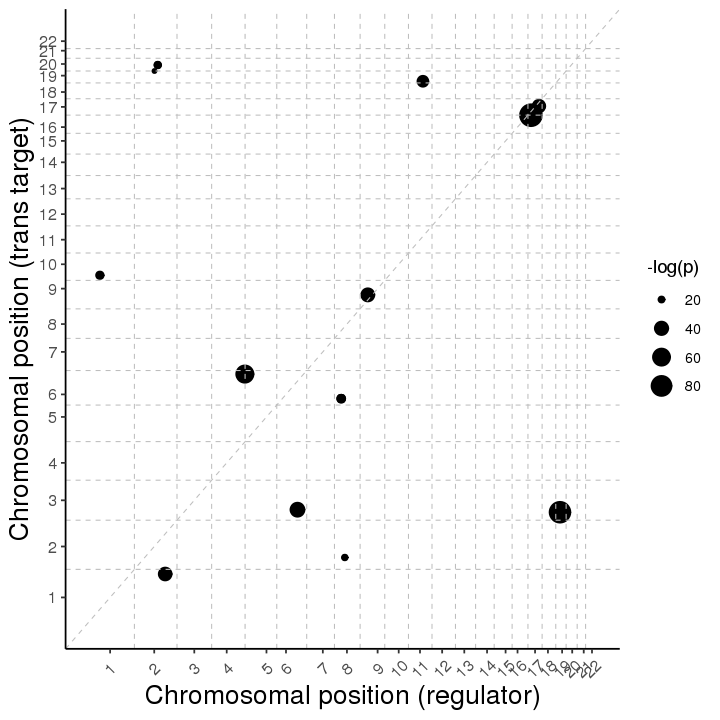

In [8]:
options(repr.plot.width = 6, repr.plot.height = 6)

sig$p <- as.numeric(sig$p)
chr_labs <- as.character(c(1:22))

boundaries <- c()
for(i in 1:21) {
    boundaries <- c(boundaries, max(gene_pos[gene_pos$chr == i,]$pos))
}

p <- ggplot(sig, aes(x = pos.y, y = pos.x)) +
    geom_point(aes(size = -log(p)), color = "black") +
    scale_x_continuous(name = "Chromosomal position (regulator)", 
                       labels = chr_labs, 
                       breaks = ticks,
                       limits = c(14404, 2875361182)) +
    scale_y_continuous(name = "Chromosomal position (trans target)", 
                       labels = chr_labs, 
                       breaks = ticks,
                       limits = c(14404, 2875361182)) +
    theme_classic() +
    theme(axis.text = element_text(size = 10),
          axis.title = element_text(size = 16),
          axis.text.x = element_text(angle = 45, vjust = 0.5)) +
    geom_hline(yintercept = boundaries, linetype = "dashed", color = "grey", size = .3) +
    geom_vline(xintercept = boundaries, linetype = "dashed", color = "grey", size = .3) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey", size = .3)
p

In [9]:
ggsave("figures/trans.png", p, width = 6, height = 6)